In [2]:
# Load and clean data

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load data
cme = pd.read_csv("../data/cme_census.csv")
stop_and_search = pd.read_csv("../data/filtered_stop_and_search.csv")

# Define boroughs
boroughs = [
    "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley", "Camden",
    "Croydon", "Ealing", "Enfield", "Greenwich", "Hackney", "Hammersmith and Fulham",
    "Haringey", "Harrow", "Havering", "Hillingdon", "Hounslow", "Islington",
    "Kensington and Chelsea", "Kingston upon Thames", "Lambeth", "Lewisham",
    "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Southwark",
    "Sutton", "Tower Hamlets", "Waltham Forest", "Wandsworth", "Westminster"
]

# Print columns before filtering
print("CME Columns before filtering:", cme.columns)

# Filter CME data
filtered_cme = cme.loc[cme['la_name'].isin(boroughs)].copy()
filtered_cme.reset_index(drop=True, inplace=True)

# Print columns before renaming
print("Filtered CME Columns before renaming:", filtered_cme.columns)

# Replace non-numeric values with NaN and drop these rows
filtered_cme['number'] = pd.to_numeric(filtered_cme['number'], errors='coerce')
filtered_cme.dropna(subset=['number'], inplace=True)

# Rename columns for consistency
filtered_cme.rename(columns={'la_name': 'Borough', 'number': 'missing_children_count'}, inplace=True)

# Convert 'missing_children_count' to integer type
filtered_cme['missing_children_count'] = filtered_cme['missing_children_count'].astype(int)

# Print columns after renaming
print("Filtered CME Columns after renaming:", filtered_cme.columns)

# Aggregate CME data by Borough and time_identifier
cme_agg = filtered_cme.groupby(['Borough', 'time_identifier'])['missing_children_count'].sum().reset_index()


CME Columns before filtering: Index(['time_period', 'time_identifier', 'geographic_level', 'country_code',
       'country_name', 'region_code', 'region_name', 'old_la_code',
       'new_la_code', 'la_name', 'filter_group', 'filter', 'number', 'pc',
       'rate'],
      dtype='object')
Filtered CME Columns before renaming: Index(['time_period', 'time_identifier', 'geographic_level', 'country_code',
       'country_name', 'region_code', 'region_name', 'old_la_code',
       'new_la_code', 'la_name', 'filter_group', 'filter', 'number', 'pc',
       'rate'],
      dtype='object')
Filtered CME Columns after renaming: Index(['time_period', 'time_identifier', 'geographic_level', 'country_code',
       'country_name', 'region_code', 'region_name', 'old_la_code',
       'new_la_code', 'Borough', 'filter_group', 'filter',
       'missing_children_count', 'pc', 'rate'],
      dtype='object')


In [3]:
#  Process Stop and Search Data

# Define function to assign term
def assign_term(date):
    if pd.Timestamp('2022-09-01') <= date <= pd.Timestamp('2022-12-16'):
        return "Autumn term"
    elif pd.Timestamp('2023-01-03') <= date <= pd.Timestamp('2023-03-31'):
        return "Spring term"
    elif pd.Timestamp('2023-04-17') <= date <= pd.Timestamp('2023-07-21'):
        return "Summer term"
    else:
        return "Out of term"

# Ensure the 'Date' column is timezone-naive
stop_and_search['Date'] = pd.to_datetime(stop_and_search['Date']).dt.tz_localize(None)

# Apply the function to the 'Date' column in stop_and_search
stop_and_search['Date'] = pd.to_datetime(stop_and_search['Date'])
stop_and_search['time_identifier'] = stop_and_search['Date'].apply(assign_term)

# Filter stop_and_search data
filtered_stop_and_search = stop_and_search.loc[stop_and_search['Borough'].isin(boroughs)].copy()

# Check columns after filtering stop_and_search
print("Filtered Stop and Search Columns:", filtered_stop_and_search.columns)

# Ensure 'Borough' column exists in both dataframes before merging
if 'Borough' in filtered_stop_and_search.columns and 'Borough' in cme_agg.columns:
    print("'Borough' column exists in both dataframes.")
else:
    raise KeyError("'Borough' column is missing in one of the dataframes.")

# Aggregate stop and search data by Borough and time_identifier
stop_and_search_agg = filtered_stop_and_search.groupby(['Borough', 'time_identifier']).size().reset_index(name='stop_search_count')

# Print aggregated columns for verification
print("Stop and Search Aggregated Data Columns:", stop_and_search_agg.columns)
print("CME Aggregated Data Columns:", cme_agg.columns)


Filtered Stop and Search Columns: Index(['Type', 'Date', 'Part of a policing operation', 'Policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'Borough',
       'time_identifier'],
      dtype='object')
'Borough' column exists in both dataframes.
Stop and Search Aggregated Data Columns: Index(['Borough', 'time_identifier', 'stop_search_count'], dtype='object')
CME Aggregated Data Columns: Index(['Borough', 'time_identifier', 'missing_children_count'], dtype='object')


The correlation between the number of stop and search incidents and the number of children missing education is: 0.03635164971997998


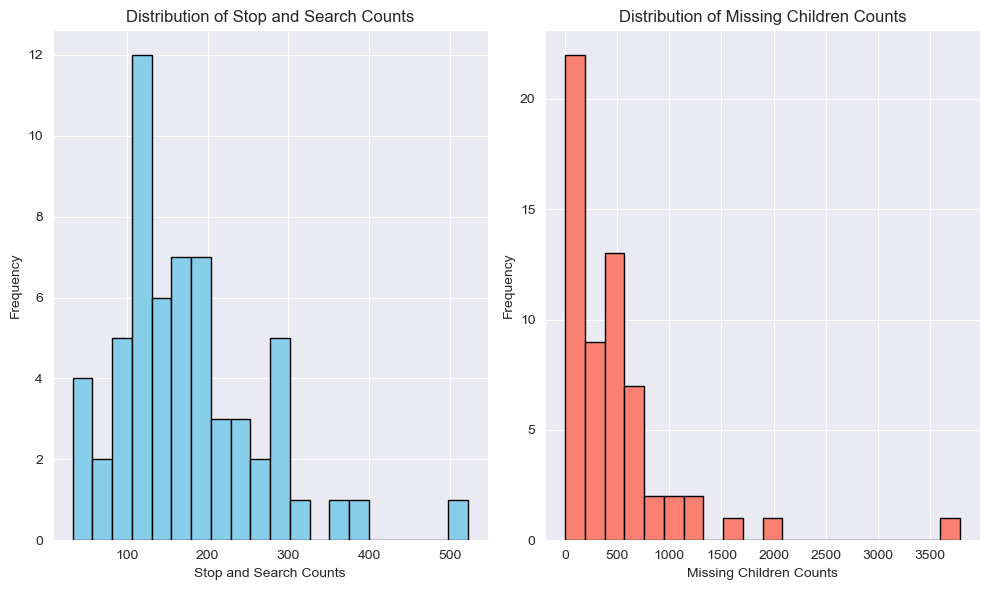

In [4]:
# Merge and compute correlation

# Merge stop and search data with CME data
merged_data = pd.merge(stop_and_search_agg, cme_agg, on=['Borough', 'time_identifier'], how='inner')

# Compute correlation
correlation = merged_data['stop_search_count'].corr(merged_data['missing_children_count'])
print("The correlation between the number of stop and search incidents and the number of children missing education is:", correlation)

# Visualize the distribution of 'stop_search_count' and 'missing_children_count'
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(merged_data['stop_search_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Stop and Search Counts')
plt.xlabel('Stop and Search Counts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(merged_data['missing_children_count'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Missing Children Counts')
plt.xlabel('Missing Children Counts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [5]:
# Train a model for predictions

# Train a simple model for illustration (replace this with your actual model training and prediction)
train_data = merged_data.copy()
X_train = train_data[['missing_children_count']]
y_train = train_data['stop_search_count']

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the trained model
X_future = future_data[['missing_children_count']]
future_data['predicted_stop_search_count'] = model.predict(X_future)


NameError: name 'future_data' is not defined

In [0]:
# Aggregate Predictions by Borough

# Aggregate predictions by Borough
borough_predictions = future_data.groupby('Borough')['predicted_stop_search_count'].sum().reset_index()

# Sort Boroughs by predicted stop and search counts
top_boroughs = borough_predictions.sort_values(by='predicted_stop_search_count', ascending=False).head(10)


In [0]:
# Printing and plotting the results of predictions

print("Top 10 Boroughs with highest predicted youth criminality (stop and search counts) in the next 12 months:")
print(top_boroughs)

plt.figure(figsize=(12, 8))
plt.bar(top_boroughs['Borough'], top_boroughs['predicted_stop_search_count'], color='purple')
plt.title('Predicted Stop and Search Counts by Borough for the Next 12 Months (Youth 10-17)')
plt.xlabel('Borough')
plt.ylabel('Predicted Stop and Search Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
